<a href="https://colab.research.google.com/github/ritikraj660/Speaker-recognition/blob/master/SR_gfcc_20_1s_frameoverlapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages:

In [1]:
!pip install soundfile
!pip install spafe

     |████████████████████████████████| 81kB 2.2MB/s 


In [2]:
import tensorflow
tensorflow.test.gpu_device_name() 

'/device:GPU:0'

# Import Data from Drive :

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = 'https://drive.google.com/file/d/1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj/view?usp=sharing'
#fluff, id = link.split('=')
id = '1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj'
print (id) 

1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj


In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('LibriSpeech.zip')  

# Extracting Data from (.)rar

In [8]:
!pip install patool
import os
os.listdir()

     |████████████████████████████████| 81kB 2.1MB/s 


['.config', 'LibriSpeech.zip', 'adc.json', 'sample_data']

In [9]:
%%time
import patoolib
patoolib.extract_archive("LibriSpeech.zip")

patool: Extracting LibriSpeech.zip ...
patool: running /usr/bin/7z x -o./Unpack_x2yy4rqv -- LibriSpeech.zip
patool: ... LibriSpeech.zip extracted to `LibriSpeech'.
CPU times: user 18.1 ms, sys: 18.1 ms, total: 36.2 ms
Wall time: 623 ms


# Audio Data Preprocessing :

In [0]:
import librosa
import soundfile
import tqdm
from scipy.io import wavfile
import glob
import os,pickle
import numpy as np
from spafe.features.mfcc import mfcc, imfcc
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

In [0]:
def norm_(x,mean = False):
    if mean == True:
        return (x - np.mean(x)) / (np.max(x) - np.min(x)) #normalization                             
    else:
        return (x-np.mean(x)/np.std(x)) #standardization

def zero_handling(x):
    """
    handle the issue with zero values if they are exposed to become an argument
    for any log function.

    Returns:
        vector with zeros substituted with epsilon values.
    """
    return np.where(x == float(0), np.finfo(float).eps, x)

In [0]:
from spafe.features.lpc import lpc
from spafe.features.gfcc import gfcc

def mfcc_(sig,fs,cep,frame_overlapp):
    mfccs  = mfcc(sig, fs=fs, num_ceps=cep, pre_emph=1, pre_emph_coeff=0.95, 
              win_len=0.025, win_hop=frame_overlapp, win_type='hamming', nfilts=26, 
              nfft=512, low_freq=None, high_freq=None, scale='constant', 
              dct_type=2, use_energy=False, lifter=22)
    #print(fs)
    return mfccs

def gfcc_(sig,fs,cep,frame_overlapp):
  gfccs = gfcc(sig, fs=fs, num_ceps=cep, pre_emph=0, 
             pre_emph_coeff=0.97, win_len=0.025, win_hop=frame_overlapp, win_type='hamming', 
             nfilts=26, nfft=512, low_freq=None, high_freq=None, scale='constant', 
             dct_type=2, use_energy=False, lifter=22, normalize=1)
  return gfccs

# combine mfcc and gfcc ceptral features
def gfcc_mfcc(y,sr,cep,frame_overlapp):
    g = gfcc_(y,sr,cep,frame_overlapp)
    m = mfcc_(y,sr,cep,frame_overlapp)
    if g.shape[0] != m.shape[0]:
        pass
    result = np.zeros([g.shape[1]+m.shape[1]])
    for i in range(g.shape[0]):
        merge = np.concatenate((m[i],g[i]))
        result = np.vstack((result,merge))
    return result[1:,:]

In [0]:
def label(user,total): # its creating lable for splited audio data
    k_train = []
    for i in range(total):
        k_train.append(user)
    y_train=np.array(k_train).T
    return y_train

In [0]:
def audioLengthInSecond(sr,m,t_s):#t_s will gives time in second[1 for 1sec, 2 for 2sec]
    t = round(sr/512) # Number of frames in one second
    totalFrame = t*t_s # Number of frames in one second * time(second)
    t1 = round(m.shape[0]/totalFrame) # total_audio_time/ t_s
    #print(time_in_sec)
    #print(" Actual audio length in second :",t1,"\n","Number of frames in one second :",t)
    j=0
    total = totalFrame*m.shape[1]
    result = np.zeros([1,total])
    #print(result.shape)
    for i in range(t1):
            temp = m[j:j+totalFrame,:].reshape(1,-1)
            diff = total-temp.shape[1]
            if round(total*0.3)>diff: # if more 30% padding need done then we will not add that audio file
                #print(diff)
                if diff!=0:
                    temp = np.concatenate((temp[0,:],temp[0,diff:diff+diff])).reshape(1,-1)
                #print("temp",temp.shape)
                result = np.concatenate((result,temp))
                j += totalFrame
            else:
                pass
    return result[1:,:]

In [0]:
from pathlib import Path
len_audio = 148
def s2c(mfcc=False,gmfcc=False,gfcc=False,cep=20,t_s=1,frame_overlapp=0.01):
    x,y=[],[]
    if gmfcc==True:
      ceps=cep+cep
    else:
      ceps=cep
    t = round(16000/512)
    totalFrame = t*t_s
    total = totalFrame*ceps    
    data = np.empty([1,total])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    #for file in tqdm(glob.iglob('/LibriSpeech/test-clean//**/*.flac', recursive=True)):
    for file in tqdm(Path('LibriSpeech/dev-clean').glob('**/*.flac')):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        signal = norm_(signal,mean = False)
        signal = zero_handling(signal)
        #print(signal.shape,sr)
        if mfcc:
            feature = mfcc_(signal,sr,cep,frame_overlapp)
            #print(feature.shape[0])
        if gmfcc:
            feature = gfcc_mfcc(signal,sr,cep,frame_overlapp)
            ceps = feature.shape[1]   
        #if feature.shape[0]>256:
        if gfcc:
            feature = gfcc_(signal,sr,cep,frame_overlapp)
        #t_s = 1
        re_data = audioLengthInSecond(sr,feature,t_s) # return (3,400)
        #print("shape of feature return ",re_data.shape)
        data=np.concatenate((data,re_data),axis=0)
        #print("Updated data length",data.shape)
        re_label = label(user,re_data.shape[0])
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:],data_label

In [31]:
%%time
def write_(x,y):
    with open('mfcc_data.csv', 'a') as mfcc_dataFile:
        writer = csv.writer(mfcc_dataFile)
        writer.writerows(x)
    mfcc_dataFile.close()
    with open('mfcc_label.csv', 'a') as mfcc_labelFile:
        writer = csv.writer(mfcc_labelFile)
        writer.writerows(y)
    mfcc_labelFile.close()

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs


In [0]:
def pre_pro(mfcc=False,gmfcc=True,gfcc=False,cep=20,dim=1,t_s=1,frame_overlapp=0.01):
  
  x,y = s2c(mfcc=mfcc,gmfcc=gmfcc,gfcc=gfcc,cep=cep,t_s=t_s,frame_overlapp=frame_overlapp)
  #write_(x,y)
  print(x.shape,y.shape,type(x),type(y))
  if dim ==2:
    if gmfcc == True:
      ceps = cep+cep
    else:
      ceps = cep   
    d = np.empty([1,round(x.shape[1]/ceps),ceps])
    for i in tqdm(range(x.shape[0])):
      t = np.reshape(x[i],(1,-1,ceps))
      d = np.concatenate((d,t),axis=0)
    #print(d.shape)
    x=d[1:,:,:]
  u = np.unique(y)
  num_classes = len(u)
  #print(u)
  d = dict()
  for enu,key in enumerate(u,0):
      d[key]=enu
  #print(d)
  for i in range(len(y)):
      y[i] = d[y[i]]  
  return x,y,num_classes

In [0]:
def data_split(x,y):
  X  = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
  print("Shape of Input data ",X.shape)
  import keras

  y_binary = keras.utils.to_categorical(y, num_classes = 10)
  #y_binary = np.asarray(list(map(int,y)))
  #print(y_binary)

  x_train, x_test, y_train, y_test = train_test_split(X,y_binary ,test_size=0.20, shuffle= True)

  print("Training shape: {0}, Training label shape : {1}".format(x_train.shape,y_train.shape))
  print("Training shape: {0}, Training label shape : {1}".format(x_test.shape,y_test.shape))
  return  x_train, x_test, y_train, y_test

# Plotting plot :



1.   **accuracy_plot()** : This function plot graph between train accuracy vs validation/test accuracy
2.   **loss_plot():** This function plot graph between train loss vs validation loss



In [0]:
import keras
from matplotlib import pyplot as plt
def accuracy_plot(history):
    plt.figure(figsize=(15,8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

def loss_plot(history):
    plt.figure(figsize=(15,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

# Creating CNN Architecture :

In [35]:
%tensorflow_version 2.x
import tensorflow 
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ModelCheckpoint
def model_(x,outputsize):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (3, 3), activation='relu'))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))
  opt = SGD(lr=0.001, momentum=0.9)                        #optimizer=keras.optimizers.Adam()
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
  #print(model.summary())
  return model
 

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas.util.testing as tm
import seaborn as sns
import numpy as np
def conf(y_test,yhat):
  y_test = np.argmax(y_test, axis=1)
  conf_mat = confusion_matrix(y_test, yhat)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d',
              xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

In [0]:
def training(model,x_train, x_test, y_train, y_test,epoch = 300,batch_sizes = 16):
  # Saving the model that performed the best on the validation set
  checkpoint = ModelCheckpoint(filepath='Model.v_2.hdf5', save_best_only=True, verbose=0)



  history = model.fit(x_train, y_train, batch_size = batch_sizes, epochs=epoch, 
                      validation_data=(x_test, y_test), verbose=0, callbacks=[checkpoint])
  #Loading the model that performed the best on the validation set
  model.load_weights('Model.v_2.hdf5')

  # Testing the model on the Test data
  (loss, accuracy) = model.evaluate(x_test, y_test, batch_size=8, verbose=1)

  yhat = np.argmax(model.predict(x_test), axis=-1)
  conf(y_test,yhat)
  accuracy_plot(history)
  loss_plot(history)
  print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))
  print('Loss on test data: {:.2f}%'.format(loss*100))
  return [accuracy*100,loss*100]

In [39]:
%%time
class speaker:

  def __init__(self,batch_sizes,epoch,mfcc,gmfcc,gfcc,cep,dim,t_s,frame_overlapp):
    self.batch_sizes = batch_sizes
    self.epoch = epoch
    self.mfcc = mfcc
    self.gmfcc = gmfcc
    self.gfcc = gfcc
    self.cep = cep
    self.dim = dim
    self.t_s = t_s
    self.frame_overlapp = frame_overlapp
    self.run()


  def run(self):
    #l = []
    x,y,num_classes = pre_pro(self.mfcc,self.gmfcc,self.gfcc,self.cep,self.dim,self.t_s,self.frame_overlapp)
    #l = len(set(y_binary))
    x_train, x_test, y_train, y_test = data_split(x,y)
    model = model_(x,num_classes)
    #l.append(training(model, x_train, x_test, y_train, y_test,self.epoch, self.batch_sizes))
    training(model, x_train, x_test, y_train, y_test,self.epoch, self.batch_sizes)
    #print("Accuracy of model {}, Loss of model {}".format(l[0],l[1]))


CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 43.6 µs


In [40]:
%%time
#speaker(batch_sizes=16,epoch=2,mfcc=False,gmfcc=True,gfcc=False,cep=20,dim=2,t_s=1,frame_overlapp=0.0075)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.7 µs


In [41]:
cep_fea = ['mfcc','gfcc','gmfcc']
cep_num = [16,18,19,20,22]
time_ = [1,2,3,4,5]
win_over = [0.015,0.01,0.0075,0.005,0.0015]
print(cep_fea,cep_num,time_,win_over)

['mfcc', 'gfcc', 'gmfcc'] [16, 18, 19, 20, 22] [1, 2, 3, 4, 5] [0.015, 0.01, 0.0075, 0.005, 0.0015]


0it [00:00, ?it/s]

*****************************************************************************
******************MFCC+GFCC = True ******** Audio length = 0.015sec*******************
*****************************************************************************


661it [00:39, 16.85it/s]
  3%|▎         | 326/10326 [00:00<00:03, 3248.23it/s]

(10326, 1240) (10326,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


100%|██████████| 10326/10326 [01:57<00:00, 88.03it/s]


Shape of Input data  (10326, 31, 40, 1)
Training shape: (8260, 31, 40, 1), Training label shape : (8260, 10)
Training shape: (2066, 31, 40, 1), Training label shape : (2066, 10)
259/259 [==============================] - 1s 3ms/step - loss: 0.1035 - accuracy: 0.9724


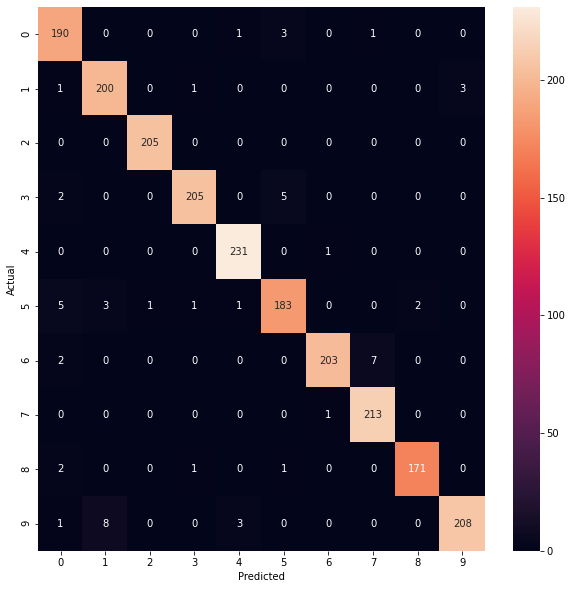

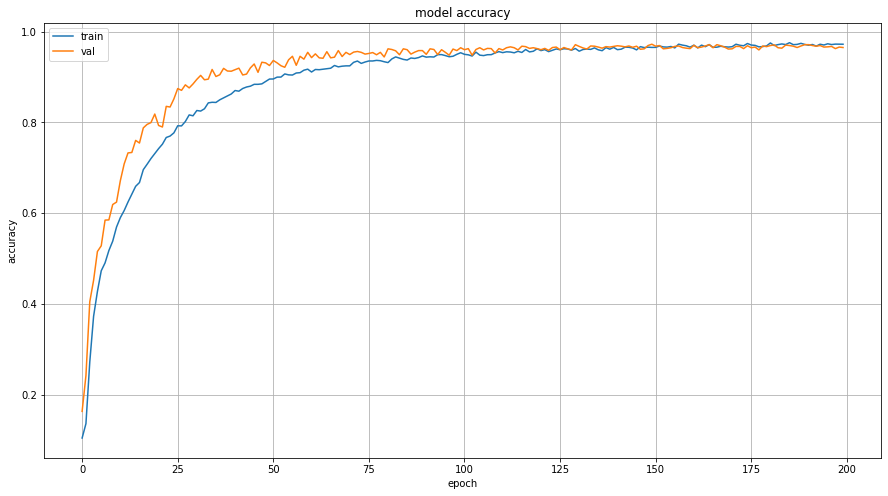

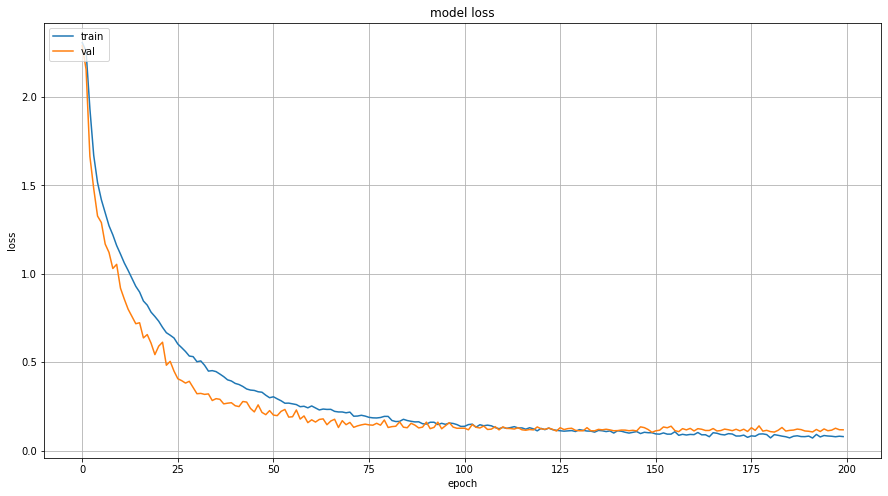

2it [00:00, 19.13it/s]

Accuracy on test data: 97.24%
Loss on test data: 10.35%
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
*****************************************************************************
*****************************************************************************
*****************************************************************************
******************MFCC+GFCC = True ******** Audio length = 0.01sec*******************
*****************************************************************************


661it [01:01, 10.72it/s]
  2%|▏         | 328/15548 [00:00<00:04, 3277.91it/s]

(15548, 1240) (15548,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


100%|██████████| 15548/15548 [04:26<00:00, 58.35it/s]


Shape of Input data  (15548, 31, 40, 1)
Training shape: (12438, 31, 40, 1), Training label shape : (12438, 10)
Training shape: (3110, 31, 40, 1), Training label shape : (3110, 10)
389/389 [==============================] - 1s 3ms/step - loss: 0.0813 - accuracy: 0.9730


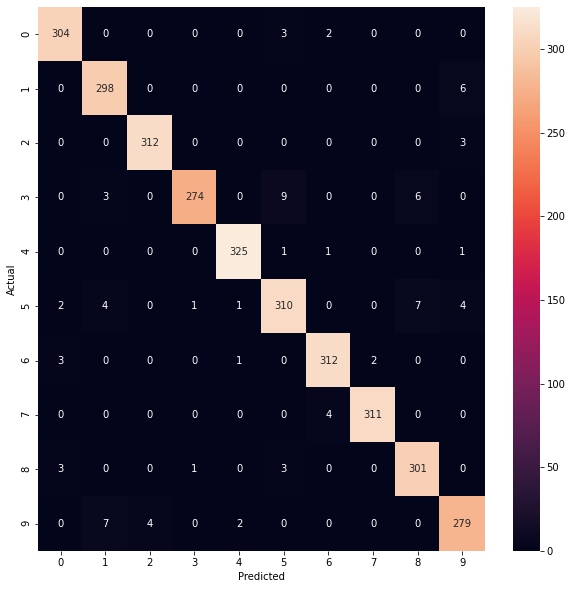

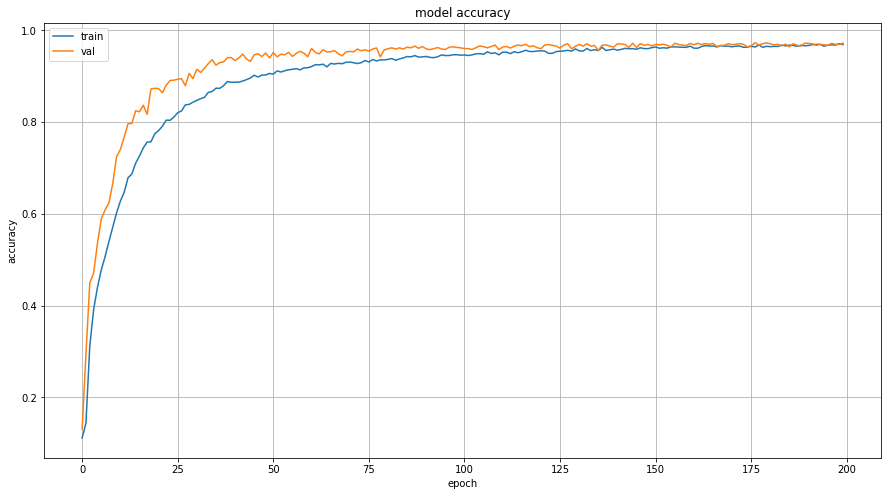

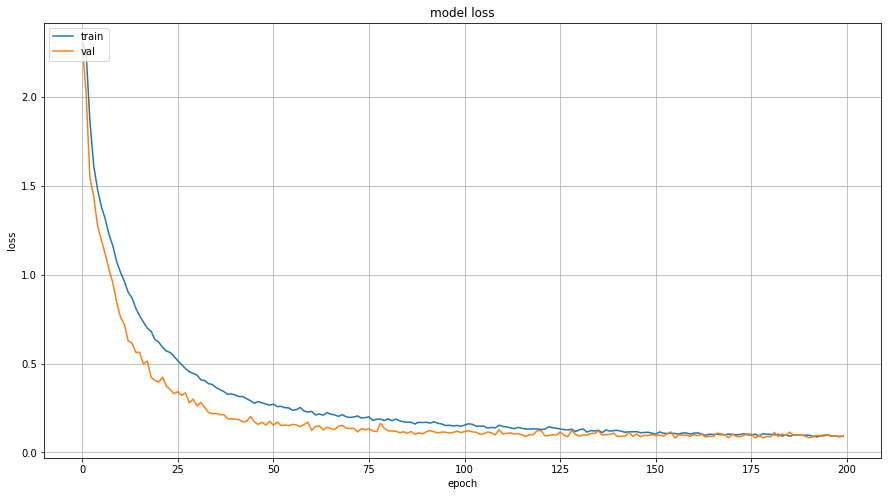

2it [00:00, 16.79it/s]

Accuracy on test data: 97.30%
Loss on test data: 8.13%
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
*****************************************************************************
*****************************************************************************
*****************************************************************************
******************MFCC+GFCC = True ******** Audio length = 0.0075sec*******************
*****************************************************************************


661it [01:21,  8.11it/s]
  2%|▏         | 342/20762 [00:00<00:05, 3413.70it/s]

(20762, 1240) (20762,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


 44%|████▎     | 9044/20762 [01:13<03:02, 64.18it/s]

In [0]:

for i in win_over:
  print("*****************************************************************************")
  print("******************MFCC+GFCC = True ******** Audio length = {}sec*******************".format(i))
  print("*****************************************************************************")
  
  speaker(batch_sizes=16,epoch=200,mfcc=False,gmfcc=True,gfcc=False,cep=20,dim=2,t_s=1,frame_overlapp = i)
  %%time
  print("*****************************************************************************")
  print("*****************************************************************************")

    

In [0]:
#import os, signal
#os.kill(os.getpid(), signal.SIGKILL)